In [24]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib  # for saving the trained model


In [25]:
# 2. Load dataset
DATA_PATH = 'pet_feeder_dataset_progressive_restock.csv'
df = pd.read_csv(DATA_PATH)


In [26]:
# 3. Data preprocessing
# 3.1 Remove duplicates
df = df.drop_duplicates()

In [27]:
# 3.2 Standardize timestamp formats and convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)

C:\Users\Wijesingha\AppData\Local\Temp\ipykernel_8948\1346102637.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')


In [28]:
# 3.3 Convert weight to numeric and forward-fill nulls
df['weight_g'] = pd.to_numeric(df['weight_g'], errors='coerce')
df['weight_g'].fillna(method='ffill', inplace=True)


C:\Users\Wijesingha\AppData\Local\Temp\ipykernel_8948\1955180160.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['weight_g'].fillna(method='ffill', inplace=True)


In [29]:
# 3.4 Sort by timestamp
df.sort_values('timestamp', inplace=True)

In [30]:
# 4. Feature engineering
# Extract time-based features
df['hour']      = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['day']       = df['timestamp'].dt.day
df['month']     = df['timestamp'].dt.month

In [31]:
# Create target: predict next weight measurement (refill prediction)
df['next_weight_g'] = df['weight_g'].shift(-1)
df.dropna(subset=['next_weight_g'], inplace=True)

In [32]:
# 5. Prepare data for modeling
FEATURES = ['weight_g', 'hour', 'dayofweek', 'day', 'month']
X = df[FEATURES]
y = df['next_weight_g']

In [33]:
# 6. Train/test split (80% train, 20% test) keeping temporal order
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [34]:
# 7. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [35]:
# 8. Model building: Random Forest with hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'max_features': ['auto', 'sqrt', 'log2']
}
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf, param_dist,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)
search.fit(X_train_scaled, y_train)
search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [36]:
# Best model from tuning
best_rf = search.best_estimator_

In [37]:
# 9. Fit the best model on the full training set
best_rf.fit(X_train_scaled, y_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      random_state=42)

In [38]:
# 10. Predictions and evaluation
preds = best_rf.predict(X_test_scaled)
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)
print(f"Best parameters: {search.best_params_}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")

Best parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 10}
Test MAE: 85.90
Test R²: 0.761


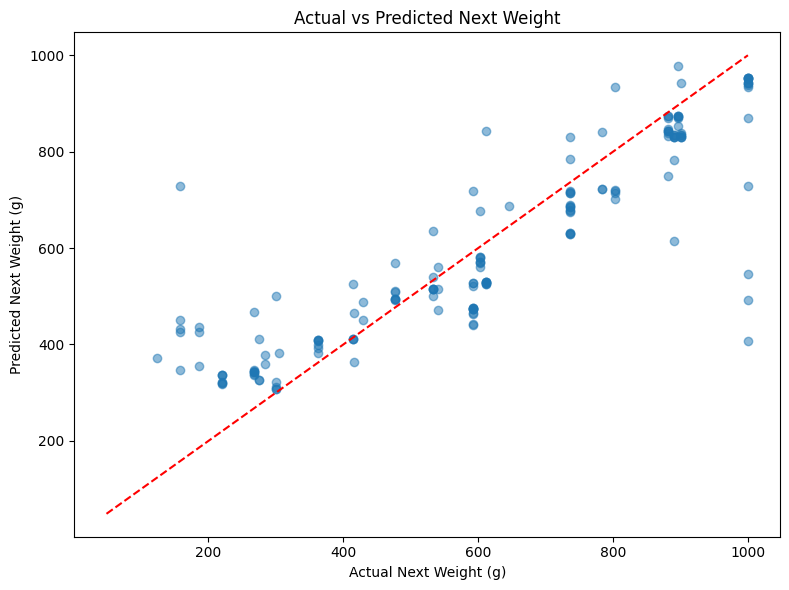

In [39]:
# 11. Plots
# 11.1 Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Next Weight (g)')
plt.ylabel('Predicted Next Weight (g)')
plt.title('Actual vs Predicted Next Weight')
plt.tight_layout()
plt.show()

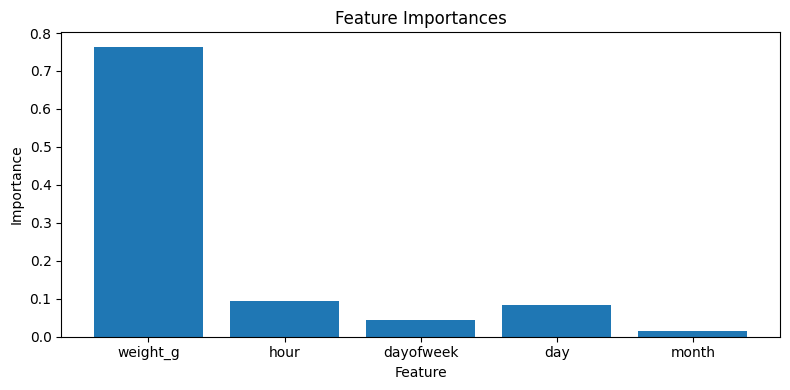

In [40]:
# 11.2 Feature importances
importances = best_rf.feature_importances_
plt.figure(figsize=(8, 4))
plt.bar(FEATURES, importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


In [41]:
# 12. Save the trained model and scaler
joblib.dump(best_rf, 'interval_regressor.joblib')
joblib.dump(scaler, 'interval_scaler.joblib')

['interval_scaler.joblib']